The tutorialis documented here https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api

I will first use this before trying my own project

In [4]:
# Modules for the Notebook
import ee
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import optimize
%matplotlib inline 
from IPython.display import Image
import folium

In [5]:
print(ee.__version__)

1.5.22


In [25]:
# Personal
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='ee-karenpedersen2') # make sure the project is your own project, not the one from the tutorial

Now we should have access to the different data products. For example there is a landcover product from MODIS the tutorial suggests we use an older one but I have instead used the newer one, we will see if this creates issues for me later in the tutorial or if it just works smoothly. 

- Land cover product: https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD12Q1

- Land Surface Temperature product: https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1

- Ground Elevation product: https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003

Notice that when we read the documentation that all products have a different level of resolution

- Land Cover: 500 m
- Land Surface: 1 km
- Ground Elevation: 30 m

In [26]:
# Data Products

# land cover
landcover = ee.ImageCollection('MODIS/061/MCD12Q1')
'MODIS/061.MCD12Q1'
# surface temperature
surface_temp = ee.ImageCollection('MODIS/006/MOD11A1')

# elevation
elevation = ee.Image('USGS/SRTMGL1_003')

It also seems note worthy that some of the data products are image collections and one in an image. The collections should be multiple images. Probably from different dates or date ranges.

In [27]:
# Time Period of Interest and Bands of Interest

# Initial date of interest (inclusive)
i_date = '2017-01-01'

# Final date of interest (exclusive)
f_date = '2020-01-01'

# Select the bands from surface_temp
surface_temp = surface_temp.select('LST_Day_1km','QC_Day')

Using either a shape file or some defined points indicate the area of interest. 

The tutorial suggests we use a point in France, but I live in Darmstadt so I will use points around there.

In [28]:
# forested location outside the city
r_lat = 49.858
r_lon = 8.69
r_point = ee.Geometry.Point(r_lon, r_lat) #creates a geometric point

# location in the city
u_lat = 49.872
u_lon = 8.65
u_point = ee.Geometry.Point(u_lon,u_lat)

In [29]:
scale = 1000 # in meters

# Elevation of urban point
elv_urban_point = elevation.sample(u_point, scale).first().get('elevation').getInfo()
print('Elevation at point selected in the city of Darmstadt:', elv_urban_point, 'm')

# Calculate and then print the mean land surface temperature for the urban point
# convert from kelvin to c and scale
lst_urban_point = surface_temp.mean().sample(u_point, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime surface temp:', round(lst_urban_point*0.02 - 273.15, 2), '°C')

# Show landcover for selected point
lc_urban_point = landcover.first().sample(u_point, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point in Darmstadt is:', lc_urban_point)

Elevation at point selected in the city of Darmstadt: 152 m
Average daytime surface temp: 22.45 °C
Land cover value at urban point in Darmstadt is: 13


Pretty cool right! But I do not know what land cover "13" is. Consulting the documentation we find this definition: __"At least 30% impervious surface area including building materials, asphalt, and vehicles."__

So now we have information about a single point but not really much else, and probably we could find similar infromation pretty easily without using ee. 

### Now we can create a time series!


In [30]:
# Point Specific Temperature Information

# Get surface temp information for our urban point
lst_urban_point = surface_temp.getRegion(u_point, scale).getInfo()

# Get surface temp information for our rural point
lst_rural_point = surface_temp.getRegion(r_point, scale).getInfo()

# See a small part of the data
lst_rural_point[:15]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2000_02_24', 8.69120037385637, 49.86098984505404, 951350400000, None, 2],
 ['2000_02_25', 8.69120037385637, 49.86098984505404, 951436800000, None, 2],
 ['2000_02_26', 8.69120037385637, 49.86098984505404, 951523200000, None, 2],
 ['2000_02_27', 8.69120037385637, 49.86098984505404, 951609600000, 14100, 0],
 ['2000_02_28', 8.69120037385637, 49.86098984505404, 951696000000, 14351, 81],
 ['2000_02_29', 8.69120037385637, 49.86098984505404, 951782400000, None, 2],
 ['2000_03_01', 8.69120037385637, 49.86098984505404, 951868800000, None, 2],
 ['2000_03_02', 8.69120037385637, 49.86098984505404, 951955200000, None, 2],
 ['2000_03_03', 8.69120037385637, 49.86098984505404, 952041600000, None, 2],
 ['2000_03_04', 8.69120037385637, 49.86098984505404, 952128000000, 13811, 65],
 ['2000_03_05', 8.69120037385637, 49.86098984505404, 952214400000, None, 2],
 ['2000_03_06', 8.69120037385637, 49.86098984505404, 952300800000, 14045, 0],
 ['

There are a lot of 'None' values in the column 'LST_Day_1km' which is our column of interest. The 'QC_Day' column in those cases has a 2 indicating that clouds prevent the calculation of such data.

The output for our points of interest is an array and we would like that array to be transformed to a dataframe so that it can be manipulated in with pandas.

In [31]:
# function to create a df from an array
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [32]:
# convert array to df
lst_df_urban = ee_array_to_df(lst_urban_point,['LST_Day_1km'])
lst_df_rural = ee_array_to_df(lst_rural_point,['LST_Day_1km'])

# function to convert between kelvin and celsius and apply scale
def t_modis_to_celsius(t_modis):
    """Converts MODIS temperature from kelvin to degrees Celsius. """
    t_celsius = 0.02*t_modis - 273.15
    return t_celsius

# Apply the function 
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

# Check the df
lst_df_rural.head()

,time,datetime,LST_Day_1km
3,951609600000,2000-02-27,8.85
4,951696000000,2000-02-28,13.87
9,952128000000,2000-03-04,3.07
11,952300800000,2000-03-06,7.75
18,952905600000,2000-03-13,13.35


The output seems reasonable at a glance.

We can model seasonality using this paper like in the example https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JZ070i012p02821.

In [33]:
# Fitting curves

# X will be time values
x_data_urban = np.asanyarray(lst_df_urban['time'].apply(float))
x_data_rural = np.asanyarray(lst_df_rural['time'].apply(float))
# Y will be temperature values
y_data_urban = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))
y_data_rural = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))

# define the fitting function and parameters
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)
# Optimize the parameters using a good start p0.
# Combine urban and rural temperature data
combined_data = np.concatenate([y_data_urban, y_data_rural])

# Calculate lst0 and delta_lst from the combined data
lst0 = combined_data.mean()  # Mean temperature
delta_lst = combined_data.max() - combined_data.min()  # Temperature range
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_urban, params_covariance_urban = optimize.curve_fit(
    fit_func, x_data_urban, y_data_urban, p0=[lst0, delta_lst, tau, phi])
params_rural, params_covariance_rural = optimize.curve_fit(
    fit_func, x_data_rural, y_data_rural, p0=[lst0, delta_lst, tau, phi])

print("lst_df_urban['datetime'] shape:", lst_df_urban['datetime'].shape)
print("x_data_urban shape:", x_data_urban.shape)
print("fit_func output shape:", fit_func(x_data_urban, params_urban[0], params_urban[1], params_urban[2], params_urban[3]).shape)

lst_df_urban['datetime'] shape: (2574,)
x_data_urban shape: (2574,)
fit_func output shape: (2574,)


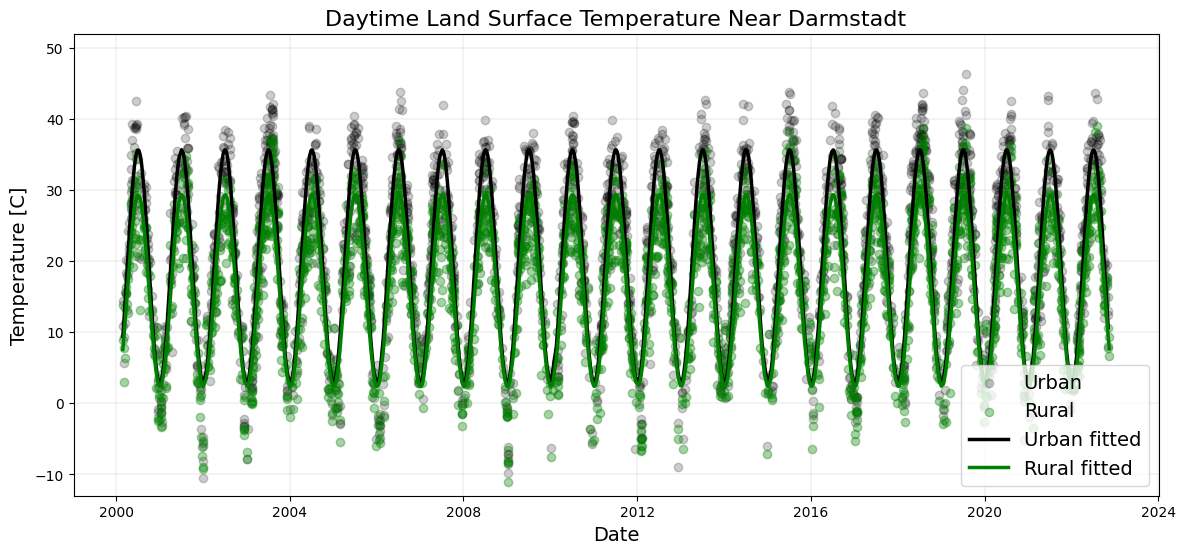

In [34]:

# Visualize the data
fig, ax = plt.subplots(figsize=(14,6))

# Add scatter plots
ax.scatter(lst_df_urban['datetime'],lst_df_urban['LST_Day_1km'],
           c = 'black', alpha=0.2, label = 'Urban')
ax.scatter(lst_df_rural['datetime'],lst_df_rural['LST_Day_1km'],
           c = 'green', alpha=0.35, label = "Rural")

# Add curves from fitted model
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_urban, params_urban[0],
                 params_urban[1],
                 params_urban[2],
                 params_urban[3]),
                 label="Urban fitted", color = 'black', lw = 2.5)

ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_rural, params_rural[0],
                 params_rural[1],
                 params_rural[2],
                 params_rural[3]),
                 label="Rural fitted", color = 'green', lw = 2.5)
# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Darmstadt', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-13, 52)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()


That is pretty cool it would be fun to do it for other parts of the world.

### Maps of Areas 
Temperature
Elevation

In [16]:
# Define the area of interest using the urban point and providing a buffer of 1000 km
area_of_interest = u_point.buffer(1e6)

Because we will plot single values for each pixel/gps point despite the dynamic nature of some data like temperature for the same point (like the figure above).This means data for each point needs to be transformed into a single value. In this case we will use mean temperature for the pixel. Elevation is not as dynamic in this way.

In [17]:
# Mean temp
lst_img = surface_temp.mean()

# The documentation for this data product suggests that the values should be scaled
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert from Kelvin to Celsius
lst_img = lst_img.select('LST_Day_1km').add(-273.15)


We will use `getThumUrl()`method from what I understand this will allow us to set the color gradient edges when plotting, and display a thumbnail.

In [18]:
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions':512, 'region': area_of_interest,
    'palette':['blue','yellow','orange','red']})
print(url)

# Display the thumbnail with the color palette
print('\nPlease be patient loading the thumbnail will take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/ee-karenpedersen2/thumbnails/94cca7ae1e95ffc581d9edba74cdb3fe-b4699a899e62098f099652fbd041ef0d:getPixels

Please be patient loading the thumbnail will take a moment...


It does take a bit to load, the cell itself runs but the thumbnail takes time to appear due.

The image is pretty cool and shows the mountains and the northern areas pretty clearly in blue!

That was so much fun lets do it again but for elevation!

In [19]:
# this makes pixels with an elevation below sea level transparent
elv_img = elevation.updateMask(elevation.gt(0))

print("It will be worth the wait...")
# Thumbnail of the elevation for the area of interest
Image(url=elv_img.getThumbUrl({
    'min': 0, 'max': 2000, 'dimensions':512, 'region': area_of_interest,
    'palette':['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))



It will be worth the wait...


The area we have been working with is much much larger, than nessesary so lets fo ahead and make it smaller for the next exercise.

In [20]:
# create a buffer of ~10 meters around the central point
darmstadt = u_point.buffer(1000) # meters

# elevation map
print("cool elevation map incoming!!!!")
Image(url=elv_img.getThumbURL({
    'min':130, 'max':390, 'region': darmstadt,'dimensions':512,
    'palette':['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}))


cool elevation map incoming!!!!


okay maybe not so cool

In [21]:
url = lst_img.getThumbUrl({
    'min': 15, 'max': 26, 'dimensions':512, 'region': darmstadt,
    'palette':['blue','yellow','orange','red']})

# Display the thumbnail with the color palette
print('\nPlease be patient loading the thumbnail will take a moment...')
Image(url=url)


Please be patient loading the thumbnail will take a moment...


Also less interesting....

Okay so that was les than impressive lets move back to a larger more impressive scale

In [22]:
# Get the collection of political boundries
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to Germany
germany = countries.filter(ee.Filter.eq('ADM0_NAME', 'Germany'))

# Clip the temp image to Germany
temp_de = lst_img.clip(germany)

# Image
print("cool image incoming... just you wait!!!")

url = temp_de.getThumbUrl({
    'min':10, 'max':26, 'region':area_of_interest, 'dimensions':512,
    'palette': ['blue', 'yellow', 'orange', 'red']
})

Image(url=url)

cool image incoming... just you wait!!!


### Interactive maps
Using the module `folium` we can make interactive maps with some of the data products we have already explored.

In [23]:
# city center (more or less)
lat,lon = 49.87,8.65

map_darmstadt = folium.Map(location=[lat,lon], zoom_start=10)
map_darmstadt

nice we can scroll around